In [22]:
# 1. Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
df = pd.read_csv("C:\\Users\\Chandupa Weerakkody\\Documents\\AIML_LivePROJECT\\2019.csv")

print(df.head())

      FL_DATE OP_UNIQUE_CARRIER  OP_CARRIER_FL_NUM ORIGIN DEST  DEP_TIME  \
0  2019-01-01                9E               3280    GNV  ATL     601.0   
1  2019-01-01                9E               3281    MSP  CVG    1359.0   
2  2019-01-01                9E               3282    DTW  CVG    1215.0   
3  2019-01-01                9E               3283    TLH  ATL    1521.0   
4  2019-01-01                9E               3284    ATL  FSM    1847.0   

   DEP_DELAY  TAXI_OUT  WHEELS_OFF  WHEELS_ON  ...  ARR_TIME  ARR_DELAY  \
0        1.0      22.0       623.0      714.0  ...     722.0       -1.0   
1       -5.0      15.0      1414.0     1629.0  ...    1633.0      -36.0   
2       -5.0      18.0      1233.0     1323.0  ...    1329.0      -16.0   
3       -6.0      14.0      1535.0     1618.0  ...    1625.0      -14.0   
4      -15.0      18.0      1905.0     1935.0  ...    1940.0      -25.0   

   AIR_TIME  DISTANCE  CARRIER_DELAY  WEATHER_DELAY  NAS_DELAY  \
0      51.0     300.0     

In [26]:
print("Shape BEFORE:", df.shape)
print("\nColumns:\n", list(df.columns))
print("\nHead:\n", df.head(3))



Shape BEFORE: (7422037, 21)

Columns:
 ['FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'ARR_TIME', 'ARR_DELAY', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'Unnamed: 20']

Head:
       FL_DATE OP_UNIQUE_CARRIER  OP_CARRIER_FL_NUM ORIGIN DEST  DEP_TIME  \
0  2019-01-01                9E               3280    GNV  ATL     601.0   
1  2019-01-01                9E               3281    MSP  CVG    1359.0   
2  2019-01-01                9E               3282    DTW  CVG    1215.0   

   DEP_DELAY  TAXI_OUT  WHEELS_OFF  WHEELS_ON  ...  ARR_TIME  ARR_DELAY  \
0        1.0      22.0       623.0      714.0  ...     722.0       -1.0   
1       -5.0      15.0      1414.0     1629.0  ...    1633.0      -36.0   
2       -5.0      18.0      1233.0     1323.0  ...    1329.0      -16.0   

   AIR_TIME  DISTANCE  CARRIER_DELAY  WEATHER_DE

In [28]:
# 2) Basic cleanup helpers

# (a) Drop entirely empty columns (common: 'Unnamed: 20')
empty_cols = [c for c in df.columns if df[c].isna().all()]
if empty_cols:
    print("\nDropping entirely empty columns:", empty_cols)
    df = df.drop(columns=empty_cols)



Dropping entirely empty columns: ['Unnamed: 20']


In [30]:
# (b) Strip whitespace-only strings to NaN
df = df.replace(r"^\s*$", np.nan, regex=True)

In [31]:
# (c) Ensure date is datetime
if "FL_DATE" in df.columns:
    df["FL_DATE"] = pd.to_datetime(df["FL_DATE"], errors="coerce")

In [32]:
# 3) Inspect missingness

missing_counts = df.isna().sum().sort_values(ascending=False)
print("\nMissing values per column (top 15):\n", missing_counts.head(15))


Missing values per column (top 15):
 LATE_AIRCRAFT_DELAY    6032784
SECURITY_DELAY         6032784
NAS_DELAY              6032784
WEATHER_DELAY          6032784
CARRIER_DELAY          6032784
AIR_TIME                153805
ARR_DELAY               153805
WHEELS_ON               137647
TAXI_IN                 137647
ARR_TIME                137646
WHEELS_OFF              133977
TAXI_OUT                133977
DEP_DELAY               130110
DEP_TIME                130086
OP_UNIQUE_CARRIER            0
dtype: int64


In [36]:
# 4) Choose strategies per column type

# Delay-cause columns often appear as NaN when “not applicable”.
delay_cause_cols = [
    "CARRIER_DELAY",
    "WEATHER_DELAY",
    "NAS_DELAY",
    "SECURITY_DELAY",
    "LATE_AIRCRAFT_DELAY",
]

# If these columns exist, convert NaN -> 0 (meaning: no delay attributed to that cause)
existing_cause_cols = [c for c in delay_cause_cols if c in df.columns]
if existing_cause_cols:
    df[existing_cause_cols] = df[existing_cause_cols].fillna(0)

# Times can be missing when flights are cancelled/diverted. If you don’t have CANCELLED/DIVERTED,
# we’ll leave times as-is and only impute core numeric features safely.
# Identify numeric vs categorical
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

# Optional: If DEP_DELAY or ARR_DELAY are *crucial* for your downstream steps,
# you can choose to drop rows missing both (very rare / incomplete rows).
essential_pairs_missing = df["DEP_DELAY"].isna() & df["ARR_DELAY"].isna() if {"DEP_DELAY","ARR_DELAY"}.issubset(df.columns) else pd.Series(False, index=df.index)
dropped_both = int(essential_pairs_missing.sum())
if dropped_both > 0:
    print(f"\nDropping rows missing BOTH DEP_DELAY and ARR_DELAY: {dropped_both}")
    df = df.loc[~essential_pairs_missing].copy()

# For remaining numeric NaNs (excluding the cause columns we already filled),
# use median imputation (robust to skew)
numeric_to_impute = [c for c in num_cols if c not in existing_cause_cols]
median_values = df[numeric_to_impute].median(numeric_only=True)
df[numeric_to_impute] = df[numeric_to_impute].fillna(median_values)

# For categorical NaNs, fill with mode (most frequent). If all NaN, skip safely.
for c in cat_cols:
    if df[c].isna().any():
        try:
            mode_val = df[c].mode(dropna=True)
            if len(mode_val) > 0:
                df[c] = df[c].fillna(mode_val.iloc[0])
        except Exception:
            # If mode fails (e.g., all NaN), leave as-is
            pass



Dropping rows missing BOTH DEP_DELAY and ARR_DELAY: 130110


In [38]:
# 5) Verify after handling

print("\nMissing values AFTER handling (top 15):\n", df.isna().sum().sort_values(ascending=False).head(15))
print("Shape AFTER:", df.shape)


Missing values AFTER handling (top 15):
 FL_DATE              0
OP_UNIQUE_CARRIER    0
SECURITY_DELAY       0
NAS_DELAY            0
WEATHER_DELAY        0
CARRIER_DELAY        0
DISTANCE             0
AIR_TIME             0
ARR_DELAY            0
ARR_TIME             0
TAXI_IN              0
WHEELS_ON            0
WHEELS_OFF           0
TAXI_OUT             0
DEP_DELAY            0
dtype: int64
Shape AFTER: (7291927, 20)


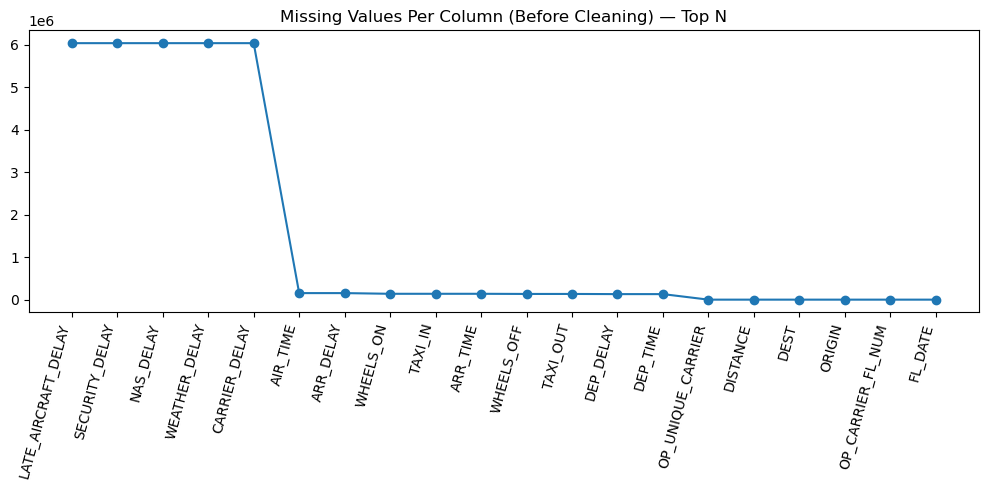

In [40]:
# 6) Simple EDA plots for viva

# (A) Bar chart of missingness BEFORE vs AFTER (counts)
plt.figure(figsize=(10, 5))
(before_counts,) = plt.plot(missing_counts.values, marker="o")
plt.title("Missing Values Per Column (Before Cleaning) — Top N")
plt.xticks(ticks=range(len(missing_counts.head(20))), labels=missing_counts.head(20).index, rotation=75, ha="right")
plt.tight_layout()
plt.show()


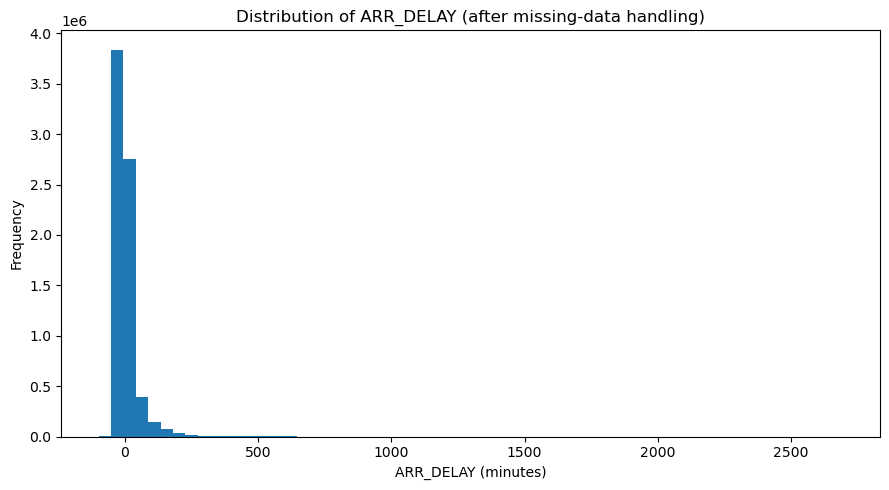

In [42]:
# (B) Histogram of ARR_DELAY (post-clean)
if "ARR_DELAY" in df.columns:
    plt.figure(figsize=(9, 5))
    plt.hist(df["ARR_DELAY"], bins=60)
    plt.title("Distribution of ARR_DELAY (after missing-data handling)")
    plt.xlabel("ARR_DELAY (minutes)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

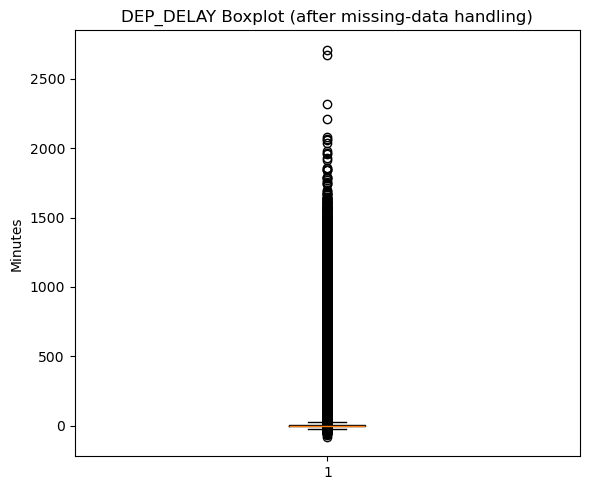

In [44]:
# (C) Boxplot of DEP_DELAY (post-clean)
if "DEP_DELAY" in df.columns:
    plt.figure(figsize=(6, 5))
    plt.boxplot(df["DEP_DELAY"].dropna())
    plt.title("DEP_DELAY Boxplot (after missing-data handling)")
    plt.ylabel("Minutes")
    plt.tight_layout()
    plt.show()

In [46]:
# 7) Save for next member in line

# Save to results/outputs/ (portable path if you’re using the assignment folder layout)
out_dir = "C:\\Users\\Chandupa Weerakkody\\Documents\\AIML_LivePROJECT\\output"
try:
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, "after_missing.csv")
except Exception:
    # fallback to a sibling 'results/outputs' next to your CSV
    fallback_dir = os.path.join(os.path.dirname(DATA_PATH), "..", "results", "outputs")
    os.makedirs(fallback_dir, exist_ok=True)
    out_path = os.path.join(fallback_dir, "after_missing.csv")

df.to_csv(out_path, index=False)
print(f"\nSaved cleaned dataset to: {out_path}")


Saved cleaned dataset to: C:\Users\Chandupa Weerakkody\Documents\AIML_LivePROJECT\output\after_missing.csv
